# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [2]:
"""
Helper function to visualize the quality of the solution
"""
def plotter(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Loading data 2D: Stacking on frequency

In [13]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
#cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')
cont.load('../../bindata/fits/cubes/ALMA01000740.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.stack(axis=(0))

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [14]:
"""
Generating the data function
"""
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
f = sp.interpolate.interp2d(x, y, data, kind='linear')
#x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

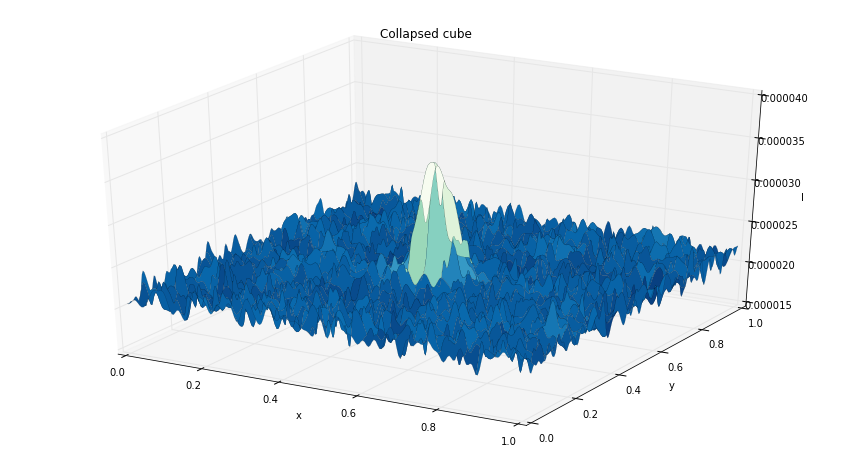

In [21]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='GnBu_r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Collapsed cube')
plt.show()

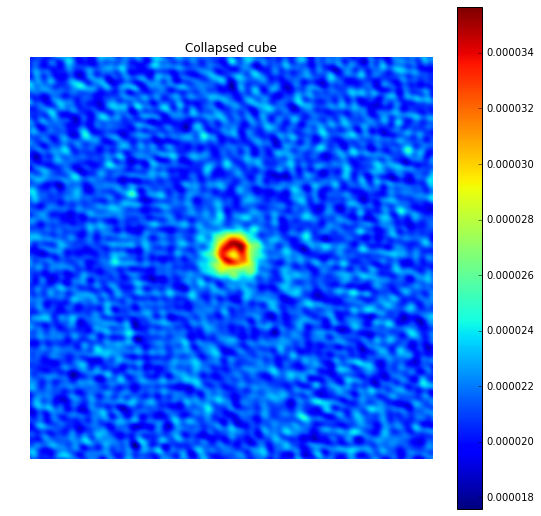

In [20]:
plt.figure(figsize=(9,9))
plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
plt.colorbar()
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}=$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$

In [46]:
z = sym.Symbol('z')

#Penalizing function and its derivatives
#psi1 = sym.exp(z)
#d1psi1 = sym.diff(psi1, z)
#d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')
def d1psi1(x, scale=10.):
    x = scale*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('(4*(x-1)*x+2) / (4*(x-1)**2 * x**2 * (cosh(1/x + 1/(x-1))+1))')
    return ret
    

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

## $\phi$-RBF function to use and its derivatives

In [47]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, sig):
    retval = ne.evaluate('exp(-(x**2+y**2)/(2*sig**2))')
    return retval

def phix(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * x')
    return retval

def phiy(x, y, sig):
    retval = ne.evaluate('(-1./sig**2) * exp(-(x**2+y**2)/(2*sig**2)) * y')
    return retval

#same as phiyx
def phixy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x*y)')
    return retval

def phixx(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (x**2 - sig**2)')
    return retval

def phiyy(x, y, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-(x**2+y**2)/(2*sig**2)) * (y**2 - sig**2)')
    return retval

## Euler-Lagrange function class definition

In [60]:
class ELFunc():
    def __init__(self, f, xe, ye, xc, yc, c0, sig0, d1psi1, d1psi2, d2psi2, a=0., b=0.):
        #data function at evaluation and boundary points
        f0 = f(xe,ye)
        fb = [f(0.5,0.),f(1.,0.5),f(0.5,1.),f(0.,0.5)]
        len_f0 = len(f0)
        len_xe = len(xe); len_ye = len(ye)
        len_xc = len(xc); len_yc = len(yc)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        """
        TODO:verify consistency
        """
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        """ 
        Computing distance matrix.
        Note: Evaluation and collocation points will be the same
        """
        Dx = np.empty((len_xe,len_xc))
        Dy = np.empty((len_ye,len_yc))
        for k in range(len_xe):
            Dx[k,:] = (xe[k]-xc)
        for k in range(len_ye):
            Dy[k,:] = (ye[k]-yc)
        """
        Computing the Phi-matrices
        """
        Ne = len_xe*len_ye
        Nc = len_xc*len_yc
        phi_m = np.empty((Ne,Nc))
        phix_m = np.empty((Ne,Nc))
        phiy_m = np.empty((Ne,Nc))
        phixx_m = np.empty((Ne,Nc))
        phiyy_m = np.empty((Ne,Nc))
        phixy_m = np.empty((Ne,Nc))
        for i in range(len_ye):
            for j in range(len_xe):
                dx,dy = np.meshgrid(Dx[j,:], Dy[i,:], sparse=True)
                phi_m[r_index,:] = phi(dx,dy,sig0).ravel()
                phix_m[r_index,:] = phix(dx,dy,sig0).ravel()
                phiy_m[r_index,:] = phiy(dx,dy,sig0).ravel()
                phixx_m[r_index,:] = phixx(dx,dy,sig0).ravel()
                phiyy_m[r_index,:] = phiyy(dx,dy,sig0).ravel()
                phixy_m[r_index,:] = phixy(dx,dy,sig0).ravel()
                r_index += 1
        """
        Storing important atributes
        """
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye
        self.xc = xc; self.yc = yc
        self.Dx = Dx
        self.Dy = Dy
        self.phi_m = phi_m
        self.phix_m = phix_m
        self.phiy_m = phiy_m
        self.phixx_m = phixx_m
        self.phiyy_m = phiyy_m
        self.phixy_m = phixy_m
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b

## Centers and evaluation points

In [57]:
#Number of center points on each axis
Nx = 10
Ny = 10
N = Nx*Ny

#Number of points to be evaluated at the boundary
Nb = 2*N - (int(np.sqrt(2)*Nx))*int(np.sqrt(2)*Ny)

"""Computing center points"""
xc = np.linspace(0., 1., Nx+2, endpoint=True)[1:-1]
yc = np.linspace(0., 1., Ny+2, endpoint=True)[1:-1]
print('Center points:')
print(xc); print(yc)
print('---------------------------------------------')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., int(np.sqrt(2)*Nx)+2, endpoint=True)[1:-1]
ye = np.linspace(0., 1., int(np.sqrt(2)*Ny)+2, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe); print(ye)
print('---------------------------------------------')

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
---------------------------------------------
Evaluation points:
[ 0.06666667  0.13333333  0.2         0.26666667  0.33333333  0.4
  0.46666667  0.53333333  0.6         0.66666667  0.73333333  0.8
  0.86666667  0.93333333]
[ 0.06666667  0.13333333  0.2         0.26666667  0.33333333  0.4
  0.46666667  0.53333333  0.6         0.66666667  0.73333333  0.8
  0.86666667  0.93333333]
---------------------------------------------


## Initial Conditions

In [58]:
"""
Defining initial parameter values
"""
c0 = f(xc,yc)/N
sig0 = (1./(N))*np.ones(N)

## Solving it!

In [61]:
elf = ELFunc(f, xe, ye, xc, yc, c0, sig0, d1psi1, d1psi2, d2psi2)

ValueError: operands could not be broadcast together with shapes (100,) (1,10) (10,1) 